In [1]:
import scipy.io as sio
import numpy as np
from copy import deepcopy
from scipy.optimize import minimize
from matplotlib import pyplot as plt
from scipy.special import erf
from mpl_toolkits.mplot3d import Axes3D
import cmath
import matplotlib
import hubbard_1d
import quspin
import fejer_kernel
import fourier_filter
import generate_cdf
from qcels import *
matplotlib.rcParams['font.size'] = 15
matplotlib.rcParams['lines.markersize'] = 10

In [2]:
def generate_spectrum_population_hubbard_4(eigenenergies, population, p):

    p = np.array(p)
    spectrum = eigenenergies * 0.25*np.pi/np.max(np.abs(eigenenergies))#normalize the spectrum
    q = population
    q=q/(np.sum(q)-q[0]-q[8]-q[26])*(1-p[0]-p[1]-p[2])
    q[0]=p[0]
    q[8]=p[1]
    q[26]=p[2]
    num_p = p.shape[0]
    return spectrum, q

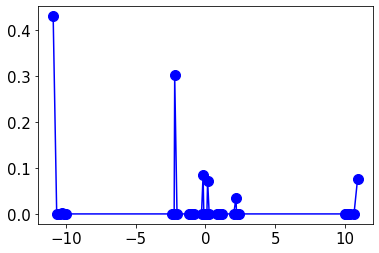

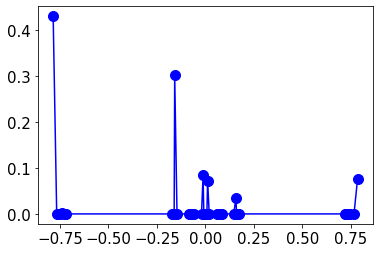

0.018254467592843104


In [3]:
###-------spectrum of Hubbard model with 4 sites---------------
num_sites = 4
J = 1.0
U = 10.0
U0 = 0.0
mu = 0.0
N_up = num_sites // 2
N_down = num_sites - N_up

num_eigenstates_max = 100

ham0 = hubbard_1d.generate_ham(num_sites, J, U0, mu, N_up, N_down)
ground_state_0 = ham0.eigsh(k=1,which="SA")[1][:,0]

ham = hubbard_1d.generate_ham(num_sites, J, U, mu, N_up, N_down)
if( num_eigenstates_max > ham.shape[0] // 2):
    eigenenergies, eigenstates = ham.eigh()
else:
    eigenenergies, eigenstates = ham.eigsh(k=num_eigenstates_max,which="SA")
ground_state = eigenstates[:,0]

population_raw = np.abs(np.dot(eigenstates.conj().T, ground_state_0))**2

plt.plot(eigenenergies,population_raw,'b-o');plt.show()

spectrum, population = generate_spectrum_population(eigenenergies, population_raw, 
                                                    [population_raw[0],population_raw[1]])

plt.plot(spectrum, population,'b-o');plt.show()

print(spectrum[1]-spectrum[0])

In [4]:
p0_array = np.array([0.25]) #initial overlap with the first eigenvector
p8_array=np.array([0.25]) #initial overlap with the second eigenvector
p26_array=np.array([0.25]) #initial overlap with the second eigenvector
T_gap = 200
N_test_QCELS = 10  #number of different circuit depths for QCELS test
N_QPE = 10  #number of different circuit depths for QCELS QPE test
T_list_QCELS = T_gap*(2**(np.arange(N_test_QCELS)))### circuit depth for QCELS
T_list_QPE = T_gap*(2**(np.arange(N_QPE)))###circuit depth for QPE
err_QCELS_ground=np.zeros((len(p0_array),len(T_list_QCELS)))
err_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
err_QCELS_ground_gaussian=np.zeros((len(p0_array),len(T_list_QCELS)))
err_QCELS_gaussian=np.zeros((len(p0_array),len(T_list_QCELS)))
err_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
cost_list_avg_QCELS = np.zeros((len(p0_array),len(T_list_QCELS)))
cost_list_avg_QCELS_gaussian = np.zeros((len(p0_array),len(T_list_QCELS)))
cost_list_avg_QPE = np.zeros((len(p0_array),len(T_list_QPE)))
rate_success_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
rate_success_QCELS_gaussian=np.zeros((len(p0_array),len(T_list_QCELS)))
rate_success_QPE=np.zeros((len(p0_array),len(T_list_QPE)))
max_T_QCELS=np.zeros((len(p0_array),len(T_list_QCELS)))
max_T_QCELS_gaussian=np.zeros((len(p0_array),len(T_list_QCELS)))
Navg = 10 #number of trying
err_thres_hold=0.01
err_thres_hold_QPE=0.01
#-----------------------------    
for a1 in range(len(p0_array)):
    p0=p0_array[a1]
    p8=p8_array[a1]
    p26=p26_array[a1]
    n_success_QCELS= np.zeros(len(T_list_QCELS))
    n_success_QCELS_gaussian= np.zeros(len(T_list_QCELS))
    n_success_QPE= np.zeros(len(T_list_QPE))
    for n_test in range(Navg):
        print("For p0,p8,p26=",[p0,p8,p26],"For N_test=",n_test+1)
        spectrum, population = generate_spectrum_population_hubbard_4(eigenenergies, 
                population_raw, [p0,p8,p26])
        spectrum=spectrum+np.random.uniform(-1,1)*0.05
        #------------------QCELS-Linear-----------------
        gamma=0
        for ix in range(len(T_list_QCELS)):
            T = T_list_QCELS[ix]
            T_0 = 5/min(spectrum[26]-spectrum[8],spectrum[8]-spectrum[0])
            NT_0 = 3000
            NT = 2000
            lambda_prior = np.array([spectrum[0],spectrum[8],spectrum[26]])+np.random.uniform(-1,1,3)/T_0
            ground_energy_estimate=np.zeros(len(lambda_prior))
            ground_energy_estimate_QCELS, cost_list_QCELS_this, max_T_QCELS_this = \
                    qcels_multimodal(spectrum, population, T_0, T, NT_0, NT, lambda_prior,gamma)#QCELS with time T
            for n in range(len(lambda_prior)):
                 ground_energy_estimate[n]=ground_energy_estimate_QCELS[3*n+2]
            ground_energy_estimate=np.sort(ground_energy_estimate)
            err_this_run_QCELS_ground = np.abs(ground_energy_estimate[0] - spectrum[0])
            err_this_run_QCELS = np.linalg.norm(ground_energy_estimate - np.array([spectrum[0],spectrum[8],spectrum[26]]))
#             err_this_run_QCELS = min(np.abs(ground_energy_estimate-spectrum[0]))
            err_QCELS_ground[a1,ix] = err_QCELS_ground[a1,ix]+np.abs(err_this_run_QCELS_ground)
            err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
            cost_list_avg_QCELS[a1,ix]=cost_list_avg_QCELS[a1,ix]+cost_list_QCELS_this
            max_T_QCELS[a1,ix]=max(max_T_QCELS[a1,ix],max_T_QCELS_this)
            if np.abs(err_this_run_QCELS)<err_thres_hold:
                n_success_QCELS[ix]+=1
                #err_QCELS[a1,ix] = err_QCELS[a1,ix]+np.abs(err_this_run_QCELS)
        #------------------QCELS-Gaussian-----------------
        gamma=1
        for ix in range(len(T_list_QCELS)):
            T = T_list_QCELS[ix]
            T_0 = 5/min(spectrum[26]-spectrum[8],spectrum[8]-spectrum[0])
            NT_0 = 3000
            NT = 2000
            lambda_prior = np.array([spectrum[0],spectrum[8],spectrum[26]])+np.random.uniform(-1,1,3)/T_0
            ground_energy_estimate=np.zeros(len(lambda_prior))
            ground_energy_estimate_QCELS, cost_list_QCELS_this, max_T_QCELS_this = \
                    qcels_multimodal(spectrum, population, T_0, T, NT_0, NT, lambda_prior,gamma)#QCELS with time T
            for n in range(len(lambda_prior)):
                 ground_energy_estimate[n]=ground_energy_estimate_QCELS[3*n+2]
            ground_energy_estimate=np.sort(ground_energy_estimate)
            err_this_run_QCELS_ground = np.abs(ground_energy_estimate[0] - spectrum[0])
            err_this_run_QCELS = np.linalg.norm(ground_energy_estimate - np.array([spectrum[0],spectrum[8],spectrum[26]]))
            err_QCELS_ground_gaussian[a1,ix] = err_QCELS_ground_gaussian[a1,ix]+np.abs(err_this_run_QCELS_ground)
            err_QCELS_gaussian[a1,ix] = err_QCELS_gaussian[a1,ix]+np.abs(err_this_run_QCELS)
            cost_list_avg_QCELS_gaussian[a1,ix]=cost_list_avg_QCELS_gaussian[a1,ix]+cost_list_QCELS_this
            max_T_QCELS_gaussian[a1,ix]=max(max_T_QCELS_gaussian[a1,ix],max_T_QCELS_this)
            if np.abs(err_this_run_QCELS)<err_thres_hold:
                n_success_QCELS_gaussian[ix]+=1
#        # ----------------- QPE -----------------------
        N_try_QPE=int(15*np.ceil(1.0/p0)) #number of QPE samples each time
        for ix in range(len(T_list_QPE)):
            T = int(T_list_QPE[ix])
            discrete_energies = 2*np.pi*np.arange(2*T)/(2*T) - np.pi 
            dist = generate_QPE_distribution(spectrum,population,2*T) #Generate QPE samples
            samp = generate_cdf.draw_with_prob(dist,N_try_QPE)
            j_min = samp.min()
            ground_energy_estimate_QPE = discrete_energies[j_min]
            err_this_run_QPE = np.abs(ground_energy_estimate_QPE-spectrum[0])
            err_QPE[a1,ix] = err_QPE[a1,ix]+np.abs(err_this_run_QPE)
            if np.abs(err_this_run_QPE)<err_thres_hold_QPE:
                n_success_QPE[ix]+=1
            cost_list_avg_QPE[a1,ix] = T*N_try_QPE
    rate_success_QCELS[a1,:] = n_success_QCELS[:]/Navg
    err_QCELS[a1,:] = err_QCELS[a1,:]/Navg
    err_QCELS_ground[a1,:] = err_QCELS_ground[a1,:]/Navg
    rate_success_QCELS_gaussian[a1,:] = n_success_QCELS_gaussian[:]/Navg
    err_QCELS_gaussian[a1,:] = err_QCELS_gaussian[a1,:]/Navg
    err_QCELS_ground_gaussian[a1,:] = err_QCELS_ground_gaussian[a1,:]/Navg
    rate_success_QPE[a1,:] = n_success_QPE[:]/Navg
    err_QPE[a1,:] = err_QPE[a1,:]/Navg
    cost_list_avg_QCELS[a1,:]=cost_list_avg_QCELS[a1,:]/Navg
    cost_list_avg_QCELS_gaussian[a1,:]=cost_list_avg_QCELS_gaussian[a1,:]/Navg


For p0,p8,p26= [0.25, 0.25, 0.25] For N_test= 1


/Users/zhiyan_ding/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


For p0,p8,p26= [0.25, 0.25, 0.25] For N_test= 2
For p0,p8,p26= [0.25, 0.25, 0.25] For N_test= 3
For p0,p8,p26= [0.25, 0.25, 0.25] For N_test= 4
For p0,p8,p26= [0.25, 0.25, 0.25] For N_test= 5
For p0,p8,p26= [0.25, 0.25, 0.25] For N_test= 6
For p0,p8,p26= [0.25, 0.25, 0.25] For N_test= 7
For p0,p8,p26= [0.25, 0.25, 0.25] For N_test= 8
For p0,p8,p26= [0.25, 0.25, 0.25] For N_test= 9
For p0,p8,p26= [0.25, 0.25, 0.25] For N_test= 10


[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[0.5 0.6 0.4 0.9 0.9 0.9 1.  1.  1.  1. ]]


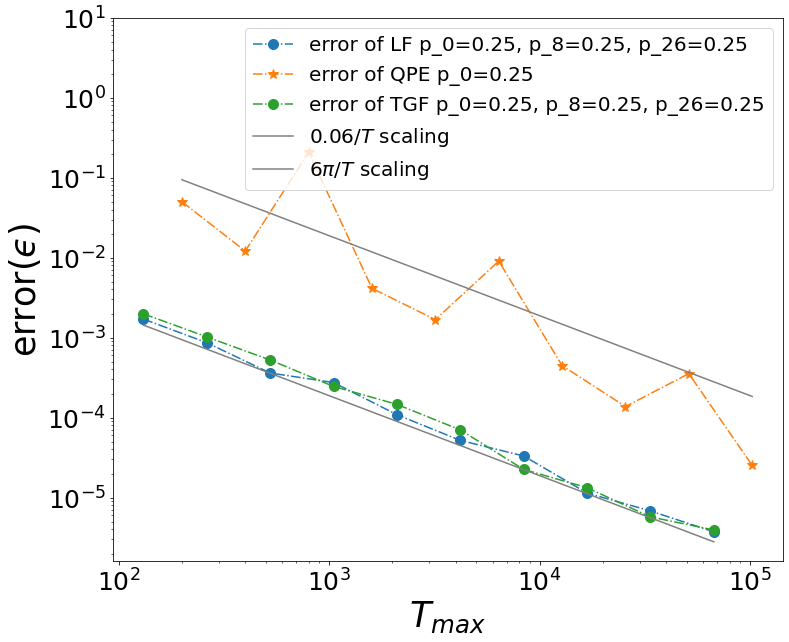

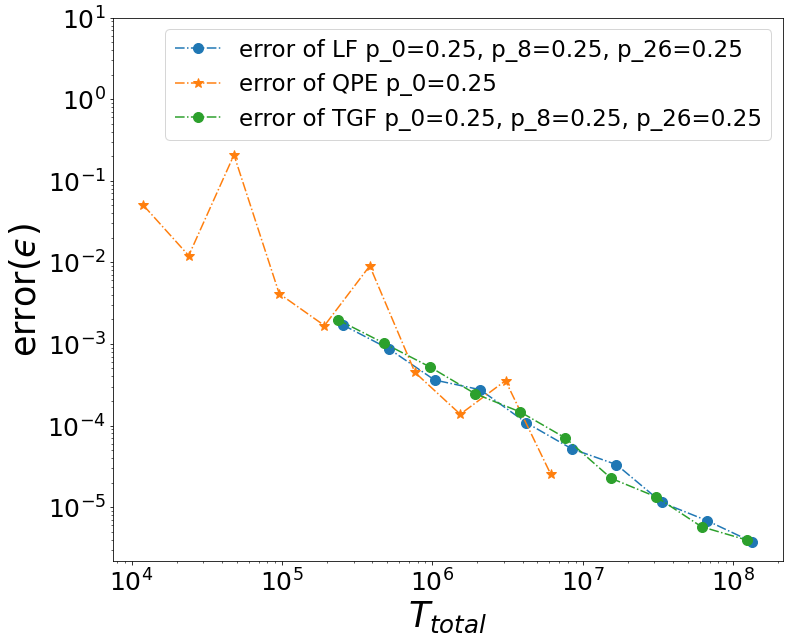

In [5]:
print(rate_success_QCELS)
print(rate_success_QCELS_gaussian)
print(rate_success_QPE)
plt.figure(figsize=(12,10))
plt.plot(max_T_QCELS[0,:],err_QCELS[0,:],linestyle="-.",marker="o",
         label="error of LF p_0={}, p_8={}, p_26={}".format(p0_array[0],p8_array[0],p26_array[0]))
plt.plot(T_list_QPE,err_QPE[0,:],linestyle="-.",marker="*",
         label="error of QPE p_0={}".format(p0_array[0]))
plt.plot(max_T_QCELS_gaussian[0,:],err_QCELS_gaussian[0,:],linestyle="-.",marker="o",
         label="error of TGF p_0={}, p_8={}, p_26={}".format(p0_array[0],p8_array[0],p26_array[0]))
plt.plot(max_T_QCELS[0,:],0.06*np.pi/max_T_QCELS[0,:],linestyle="-",color="grey",label="$0.06/T$ scaling")
plt.plot(T_list_QPE,6*np.pi/T_list_QPE,linestyle="-",color="grey",label="$6\pi/T$ scaling")
plt.xlabel("$T_{max}$",fontsize=35)
plt.ylabel("error($ϵ$)",fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=20)
plt.savefig('Hubbard_depth_4_all.pdf')
plt.figure(figsize=(12,10))
plt.plot(cost_list_avg_QCELS[0,:],err_QCELS[0,:],linestyle="-.",marker="o",
         label="error of LF p_0={}, p_8={}, p_26={}".format(p0_array[0],p8_array[0],p26_array[0]))
plt.plot(cost_list_avg_QPE[0,:],err_QPE[0,:],linestyle="-.",marker="*",
         label="error of QPE p_0={}".format(p0_array[0]))
plt.plot(cost_list_avg_QCELS_gaussian[0,:],err_QCELS_gaussian[0,:],linestyle="-.",marker="o",
         label="error of TGF p_0={}, p_8={}, p_26={}".format(p0_array[0],p8_array[0],p26_array[0]))
plt.xlabel("$T_{total}$",fontsize=35)
plt.ylabel("error($ϵ$)",fontsize=35) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=23)
plt.savefig('Hubbard_cost_4_all.pdf')
plt.show()

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]
[[0.5 0.6 0.4 0.9 0.9 0.9 1.  1.  1.  1. ]]


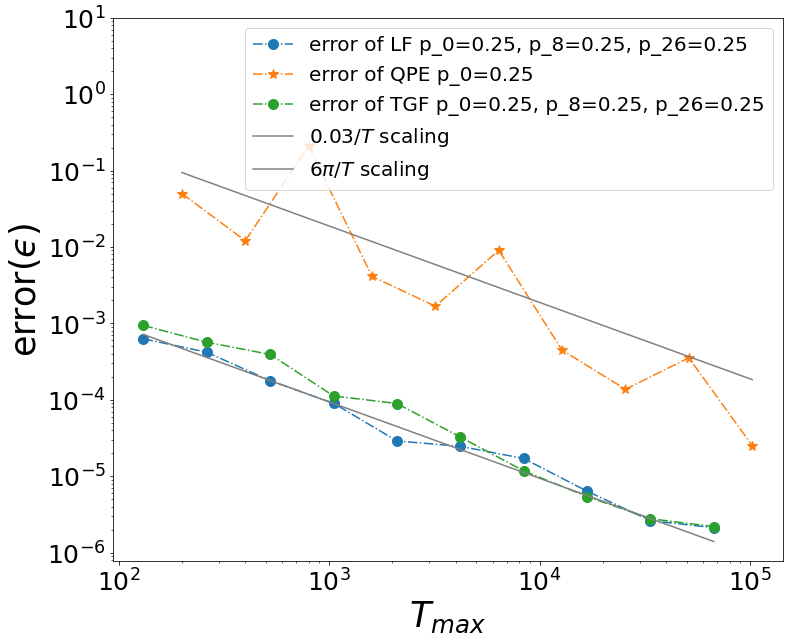

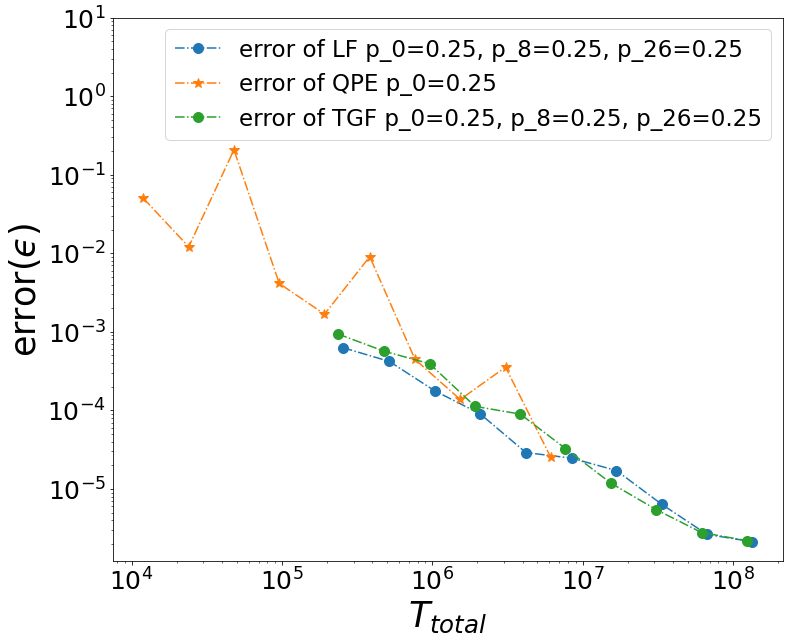

In [6]:
print(rate_success_QCELS)
print(rate_success_QCELS_gaussian)
print(rate_success_QPE)
plt.figure(figsize=(12,10))
plt.plot(max_T_QCELS[0,:],err_QCELS_ground[0,:],linestyle="-.",marker="o",
         label="error of LF p_0={}, p_8={}, p_26={}".format(p0_array[0],p8_array[0],p26_array[0]))
plt.plot(T_list_QPE,err_QPE[0,:],linestyle="-.",marker="*",
         label="error of QPE p_0={}".format(p0_array[0]))
plt.plot(max_T_QCELS_gaussian[0,:],err_QCELS_ground_gaussian[0,:],linestyle="-.",marker="o",
         label="error of TGF p_0={}, p_8={}, p_26={}".format(p0_array[0],p8_array[0],p26_array[0]))
plt.plot(max_T_QCELS[0,:],0.03*np.pi/max_T_QCELS[0,:],linestyle="-",color="grey",label="$0.03/T$ scaling")
plt.plot(T_list_QPE,6*np.pi/T_list_QPE,linestyle="-",color="grey",label="$6\pi/T$ scaling")
plt.xlabel("$T_{max}$",fontsize=35)
plt.ylabel("error($ϵ$)",fontsize=35)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=20)
plt.savefig('Hubbard_depth_4_ground.pdf')
plt.figure(figsize=(12,10))
plt.plot(cost_list_avg_QCELS[0,:],err_QCELS_ground[0,:],linestyle="-.",marker="o",
         label="error of LF p_0={}, p_8={}, p_26={}".format(p0_array[0],p8_array[0],p26_array[0]))
plt.plot(cost_list_avg_QPE[0,:],err_QPE[0,:],linestyle="-.",marker="*",
         label="error of QPE p_0={}".format(p0_array[0]))
plt.plot(cost_list_avg_QCELS_gaussian[0,:],err_QCELS_ground_gaussian[0,:],linestyle="-.",marker="o",
         label="error of TGF p_0={}, p_8={}, p_26={}".format(p0_array[0],p8_array[0],p26_array[0]))
plt.xlabel("$T_{total}$",fontsize=35)
plt.ylabel("error($ϵ$)",fontsize=35) 
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.xscale("log")
plt.yscale("log")
plt.ylim(top=10)
plt.legend(fontsize=23)
plt.savefig('Hubbard_cost_4_ground.pdf')
plt.show()

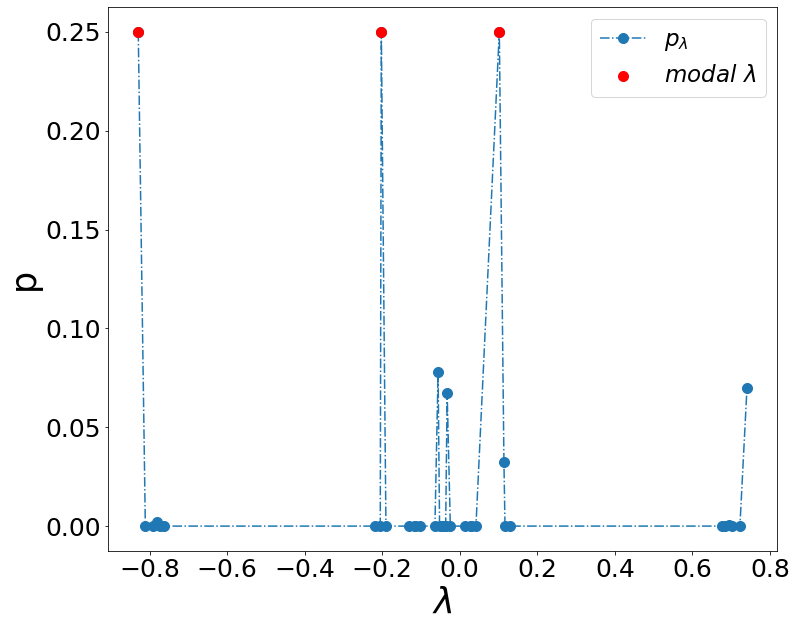

In [7]:
plt.figure(figsize=(12,10))
plt.plot(spectrum,population,linestyle="-.",marker="o",
         label="$p_{\lambda}$",zorder = 1)
plt.xlabel("$\lambda$",fontsize=35)
plt.ylabel("p",fontsize=35) 
plt.scatter([spectrum[0],spectrum[8],spectrum[26]],
            [population[0],population[8],population[26]],label=r"$modal\ \lambda$",c ="red",zorder = 2)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=23)
plt.savefig('Hubbard_4_eigendistribution.pdf')
plt.show()

In [8]:
# np.savez('result_hubbard_4sites_QPE',name1=rate_success_QPE,name2=T_list_QPE,name3=cost_list_avg_QPE,name4=err_QPE)
# np.savez('result_hubbard_4sites_QCELS',name1=rate_success_QCELS,name2=max_T_QCELS,name3=cost_list_avg_QCELS,
#          name4=err_QCELS,name5=p0_array,name6=p1_array)